# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Целевой признак: последняя измеренная температура.

Метрика: MAE

Критерии оценки

- MAE > 8.7 — 0 sp
- 7.6 < MAE ≤ 8.7 — 4 sp
- 6.8 < MAE ≤ 7.6 — 4.5 sp
- 6.3 < MAE ≤ 6.8 — 5 sp
- 6.0 < MAE ≤ 6.3 — 5.5 sp
- MAE ≤ 6.0 — 6 sp

**ПЛАН РАБОТЫ**
1. Проводим изучение информации в каждом датасете: электроды, сыпучие и проволочные материалы (объем и время добавки) и температура.
2. Проводим вычисление полной мощности и потребленной электроэнергии в разрезе каждой партии.
3. Заполняем пропуски для объема сыпучих и проволочных материалов.
4. Проводим оценку данных о температуре: группируем значения по партиям, убираем выбросы, а также партии, где всего одно измерение.
5. Проводим объединение датасетов в один.
6. Исключаем из датасета данные по времени и номеру партии.
7. Делим выборку на трейн и тест в соотношении 80 на 20.
8. Проводим масштабирование данных.
9. Обучаем модели с поиском оптимальных параметров с помощью GridSearchCV. Для обучения воспользуемся следующими алгоритмами: линейная регрессия, случайный лес, LightGBM, Сatboost.
10. Проверяем работу моделей на тестовой выборке. В качестве метрики используем MAE.

## 1 Исследовательский анализ данных и предобработка данных

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px # подключаем графическую библиотеку plotly
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None) #реализуем возможность вывода всех столбцов на экран

from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков
from sklearn.model_selection import train_test_split # деление на 2 выборки
from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
import time

In [4]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', sep=',')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv', sep=',')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', sep=',')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv', sep=',')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', sep=',')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv', sep=',')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', sep=',')

### 1.1 Изучение информации об электродах

In [5]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [6]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Итак, мы видим, что пропусков в данных по нагреву электродов нет. У нас имеются время начала и конца нагрева, значит мы можем посчитать сколько длился каждый нагрев. Также у нас есть данные по активной и реактивной мощности. Из физики известно, что активная и реактивная мощность зависимы друг от друга, далее необходимо будет проверить это предположение. Посмотрим описательные статистики по нагреву.

P.S.: Исходя из полученных данных, активная мощность скорей всего приведена в МВт, а реактивная - в МВар.

In [7]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Активная мощность не имеет сильных выбросов, чего не скажешь о реактивной - большая часть данных находится в пределах 0,29 - 0,63 (1 и 3 квартили), но имеется минимальное значение, равное -715.5 МВар. Попробуем посмотреть распределения этих двух параметров.

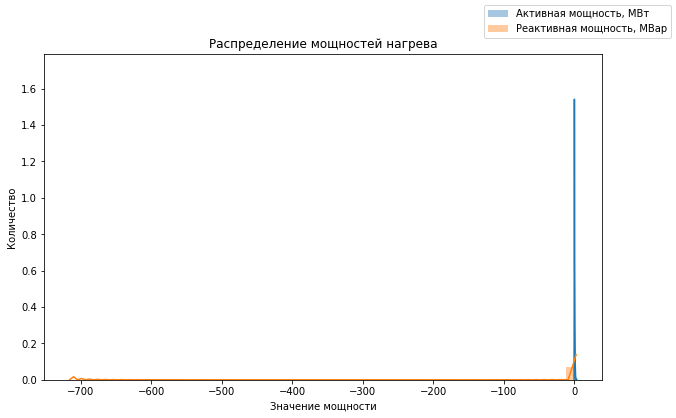

In [8]:
fig = plt.figure(figsize=(10,6))
sns.distplot(data_arc['Активная мощность'])
sns.distplot(data_arc['Реактивная мощность'])
plt.xlabel("Значение мощности")
plt.ylabel("Количество")
plt.title("Распределение мощностей нагрева")
fig.legend(labels=['Активная мощность, МВт','Реактивная мощность, МВар'])

Значительные выбросы в реактивной мощности не позволяют детально посмотреть распределение мощностей. Посмотрим на данные выбросы - выведем все значения реактивной мощности меньше 0.

In [9]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Всего одна строка по партии 2116. Выведем всю информацию по партии.

In [10]:
data_arc[data_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Скорей всего такое значение реактивной мощности является просто выбросом, поэтому чтобы не терять данные по всей партии следует его заменить средним значением по данной партии без учета выброса.

In [11]:
mean_r_power = data_arc[(data_arc['key'] == 2116) & (data_arc['Реактивная мощность'] > 0)]['Реактивная мощность'].mean()
data_arc.loc[9780, 'Реактивная мощность'] = mean_r_power

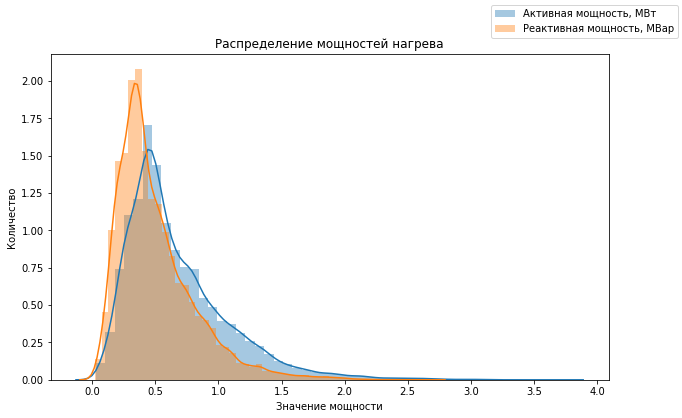

In [12]:
fig = plt.figure(figsize=(10,6))
sns.distplot(data_arc['Активная мощность'])
sns.distplot(data_arc['Реактивная мощность'])
plt.xlabel("Значение мощности")
plt.ylabel("Количество")
plt.title("Распределение мощностей нагрева")
fig.legend(labels=['Активная мощность, МВт','Реактивная мощность, МВар'])

Без значительного выброса мы видим, что распределения мощностей очень похожи и имеют близкий к нормальному характер со скосом вправо. Оценим насколько сильно данные значения зависят друг от друга.

In [13]:
data_arc['Активная мощность'].corr(data_arc['Реактивная мощность'])

0.963181241534125

Получили коэффициент корреляции практически равный 1. Если оба этих столбца сделать признаками для будущей модели, то ее качество будет хуже, нежели если в нее включить всего одну мощность. Есть 2 выхода: удалить 1 признак или можно сделать из двух признаков всего один - полную мощность, которая находится по формуле:

$$S = \sqrt{P^2 + R^2},$$

где *P* - активная мощность, <br>
*R* - реактивня мощность.

Добавим значение полной мощности.

In [14]:
data_arc['Полная мощность'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**0.5
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489


Посмотрим какое количество партий всего попали в нашу выборку.

In [15]:
len(data_arc['key'].value_counts())

3214

Всего в выборке с нагревом электродов есть данные по 3214 партиям, хотя датасет заканчивается 3241, из чего можно сделать вывод, что по каким-то партиям данные не вошли в датасет, возможно они были забракованы. 

На самом деле, знание какая мощность была во время нагрева малоинформативно. Более информативным является знание, сколько энергии было потрачено на нагрев. Для вычисления данного параметра нам нужно будет вычислить время нагрева в часах и умножить его на полную мощность, тогда мы получим затраченную энергию на каждый нагрев в МВА*ч. Если мы будем в дальнейшем вычислять время в часах, то будут получаться очень небольшие значения полной мощности в МВА * ч, ими будет неудобно пользоваться, чтобы этого избежать будем считать полную мощность в КВА*ч.

In [16]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [17]:
data_arc['Время нагрева'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']

In [18]:
data_arc['Время нагрева'] = data_arc['Время нагрева'].apply(lambda x: x.seconds)

In [19]:
data_arc['Затраченная энергия'] = data_arc['Полная мощность'] * 1000 * data_arc['Время нагрева'] / 3600

In [20]:
data_arc.sample(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева,Затраченная энергия
680,146,2019-05-08 20:01:19,2019-05-08 20:02:47,0.329319,0.225175,0.398942,88,9.751916
10181,2208,2019-07-26 21:38:13,2019-07-26 21:39:23,0.302258,0.232412,0.381281,70,7.413800
12574,2731,2019-08-14 06:06:50,2019-08-14 06:11:03,0.862123,0.689305,1.103811,253,77.573353
5306,1151,2019-06-14 06:32:43,2019-06-14 06:42:00,1.906459,1.638533,2.513837,557,388.946441
13174,2863,2019-08-19 07:56:36,2019-08-19 07:58:50,0.453573,0.294136,0.540597,134,20.122204


In [21]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева,Затраченная энергия
count,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.500710,0.838750,171.670946,53.640116
std,934.571502,0.408159,0.310874,0.509840,98.186803,71.769528
min,1.000000,0.030002,0.020806,0.036664,11.000000,0.112028
25%,806.000000,0.395297,0.291008,0.495346,107.000000,14.864208
50%,1617.000000,0.555517,0.415962,0.694922,147.000000,28.179013
75%,2429.000000,0.857034,0.637371,1.066649,214.000000,63.161286
max,3241.000000,3.731596,2.676388,4.592152,907.000000,1156.967181


In [22]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 8 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime64[ns]
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
Полная мощность         14876 non-null float64
Время нагрева           14876 non-null int64
Затраченная энергия     14876 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(2)
memory usage: 929.9 KB


Наша задача, это спрогнозировать финальную температуру, которая в дальнейшем позволит уменьшить потребление электроэнергии на этапе обработки стали. Поэтому полученные данные необходимо сгруппировать по партиями, где для каждой партии будет указан объем суммарной потребленной энергии. Суммарная потребленная энергия при этом покажет сколько энергетического ресурса понадобилось для доведения партии до оптимального химического состояния.

In [23]:
data_arc_batch = data_arc.groupby('key').agg({'Затраченная энергия': 'sum'}).reset_index()
data_arc_batch

,key,Затраченная энергия
0,1,400.660487
1,2,244.787101
2,3,145.851882
3,4,221.364253
4,5,333.093877
...,...,...
3209,3237,266.204510
3210,3238,154.407603
3211,3239,281.407700
3212,3240,202.558039


Получили сгруппированную табличку для каждой партии, проверим ее на примере 1 партии.

In [24]:
data_arc[data_arc['key'] == 1]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева,Затраченная энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228,75.597154
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185,49.282440
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172,42.810695
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365,199.783720
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148,33.186477


Данные по 1 партии совпадают, группировка выполнена верно.

### 1.2 Изучение информации о сыпучих материалах

In [25]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [26]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [27]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [28]:
len(data_bulk['key'].value_counts())

3129

In [29]:
data_bulk['key'].max()

3241

Из выведенной информации по добавленным сыпучим материалам можно заключить следующее:
1. В датасете одна строка представляет информацию по объему сыпучих материалов, добавленных в течение всего технологического процесса.
2. Состав добавления сыпучих материалов неодинаков и меняется в зависимости от того, когда партия достигает целевого химического сотава.
3. Пропуски в данных означают, что данная присадка не добавлялась для этой конкретной партии, поэтому можно их заменить на 0.
4. Данные по присадкам опять представлены не по всем партиям, это следует учесть при составлении единого датасета со всеми данными.

Заполним пропуски и проверим на выбросы.

Text(0.5, 1.0, 'Диаграмма размаха для всех сыпучих материалов')

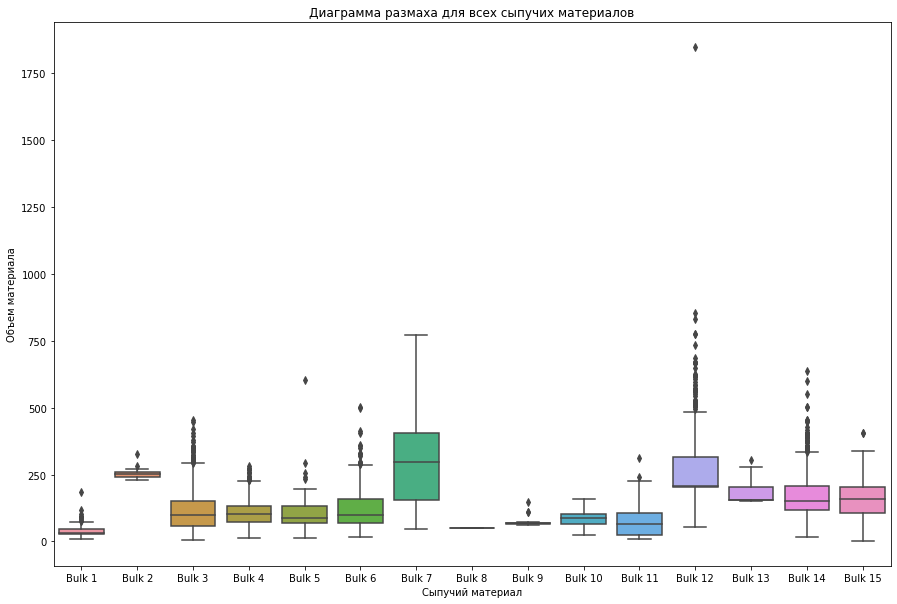

In [30]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(data=data_bulk.drop('key', axis=1))
plt.xlabel("Сыпучий материал")
plt.ylabel("Объем материала")
plt.title("Диаграмма размаха для всех сыпучих материалов")

Из диаграммы размаха видно, что существенные выбросы имеются только для присадок 5 и 12. Вполне возможно, что данные партии потребовали большее количество сыпучих материлов по сравнению со всеми остальными, поэтому удалять такие данные нецелесообразно.

In [31]:
data_bulk = data_bulk.fillna(0)

In [32]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     3129 non-null float64
Bulk 2     3129 non-null float64
Bulk 3     3129 non-null float64
Bulk 4     3129 non-null float64
Bulk 5     3129 non-null float64
Bulk 6     3129 non-null float64
Bulk 7     3129 non-null float64
Bulk 8     3129 non-null float64
Bulk 9     3129 non-null float64
Bulk 10    3129 non-null float64
Bulk 11    3129 non-null float64
Bulk 12    3129 non-null float64
Bulk 13    3129 non-null float64
Bulk 14    3129 non-null float64
Bulk 15    3129 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [33]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Данные по объемам сыпучих материалов изучены, они будут добавлены далее к общему датасету со всеми данными. Посмотрим на данные со временем добавления сыпучих материалов.

In [34]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [35]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [36]:
len(data_bulk_time['key'].value_counts())

3129

In [37]:
data_bulk_time['key'].max()

3241

Видим, что данные о времени добавления сыпучих материалов имеют ту же структуру, что и данные об объеме этих материалов. Т.к. данная задача не на временные ряды, данные о времени в общий датасет включаться не будут.

Отлично, теперь у нас есть время последнего добавления материалов по каждой партии.

### 1.3 Изучение информации о продувке газом

In [38]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [39]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [40]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


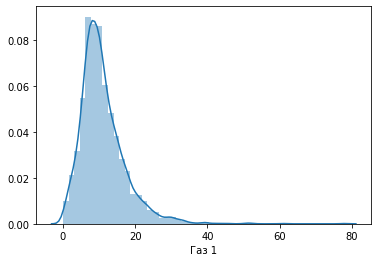

In [41]:
sns.distplot(data_gas['Газ 1'])

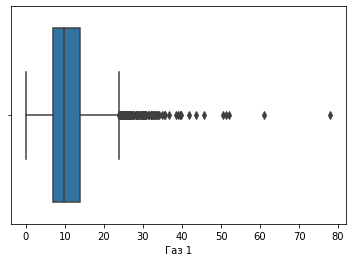

In [42]:
sns.boxplot(data_gas['Газ 1'])

In [43]:
len(data_gas['key'].unique())

3239

По добавляемому газу можно сказать следующее:
1. Газ добавляется в каждую партию без исключений - нулевые значения отсутствуют.
2. Объем газа имеет нормальное распределение слегка скошенное вправо.
3. Пропуски в данных по газу отсутствуют, по количеству партий данный параметр заполнен наиболее полно по сравнению со всеми рассмотренными выше параметрами.

Данные по объему газа могут добавляться в общую таблицу без какой либо обработки.

### 1.4 Изучение информации о проволочных материлах

Проведем исследование данных аналогично сыпучим материалам.

In [44]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [46]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [47]:
len(data_wire['key'].value_counts())

3081

In [48]:
data_wire['key'].max()

3241

Text(0.5, 1.0, 'Диаграмма размаха для всех проволочных материалов')

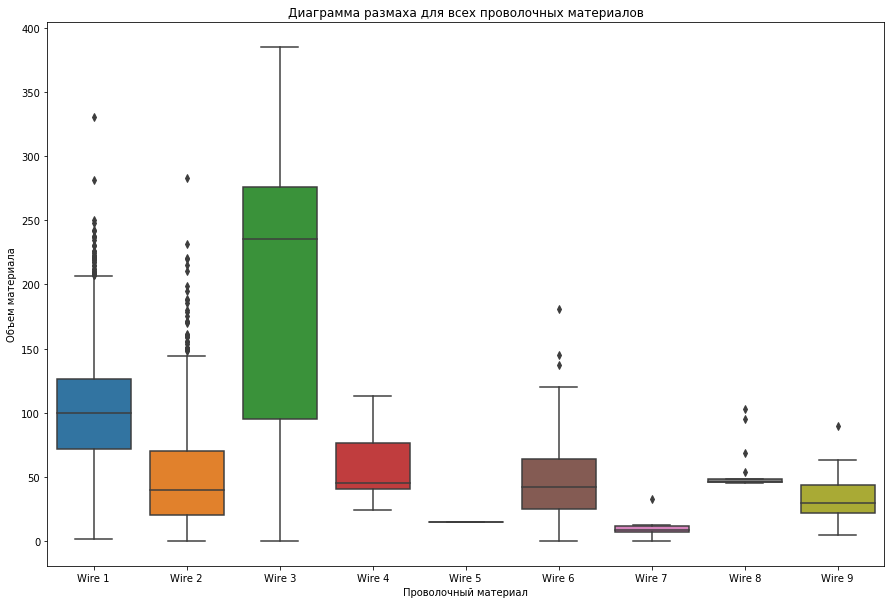

In [49]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(data=data_wire.drop('key', axis=1))
plt.xlabel("Проволочный материал")
plt.ylabel("Объем материала")
plt.title("Диаграмма размаха для всех проволочных материалов")

Анализ данных по объему проволочных материалов показал:
1. Аналогично сыпучим материалам объем материалов разнится в зависимости от партии.
2. Пропуски в данных в каком либо столбце означают отсутствие добавления этого материала для этой партии, поэтому также могут быть заменены нулями, как в случае с сыпучими материалами.
3. Значительные выбросы замечены только для проволочного материала № 8. Он добавлялся всего в 19 партий, поэтому выбросы могут быть обусловлены просто небольшим количеством данных по данному материалу.

In [50]:
data_wire = data_wire.fillna(0)

In [51]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3081 non-null float64
Wire 2    3081 non-null float64
Wire 3    3081 non-null float64
Wire 4    3081 non-null float64
Wire 5    3081 non-null float64
Wire 6    3081 non-null float64
Wire 7    3081 non-null float64
Wire 8    3081 non-null float64
Wire 9    3081 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Данные об объемах проволочных материалов рассмотрены, посмотрим на данные о времени их добавления.

In [53]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Видим, что данные о времени добавления проволочных материалов идентичны по структуре данным с объемами материалов.
Аналогично сыпучим материалам данные о времени в общий датасет не добавляем, следовательно и не обрабатываем.

### 1.5 Изучение данных о температуре

In [55]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [56]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [57]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Text(0.5, 1.0, 'Распределение замеров температуры')

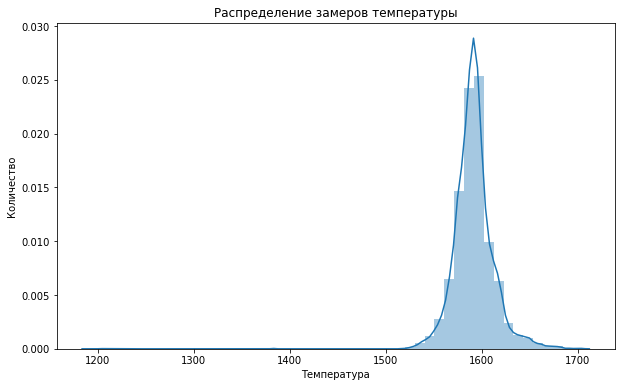

In [58]:
fig = plt.figure(figsize=(10,6))
sns.distplot(data_temp['Температура'].dropna())
plt.xlabel('Температура')
plt.ylabel("Количество")
plt.title("Распределение замеров температуры")

Text(0.5, 1.0, 'Диаграмма размаха температуры плавления')

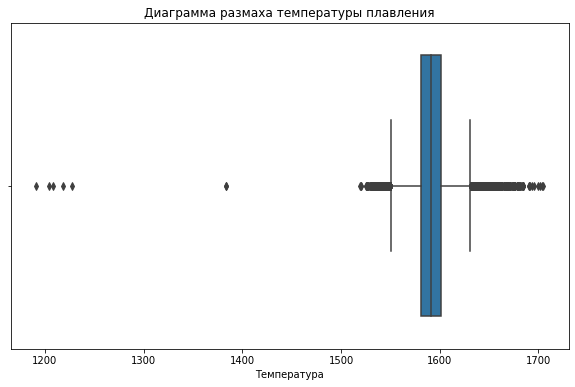

In [59]:
fig = plt.figure(figsize=(10,6))
sns.boxplot(data_temp['Температура'])
plt.xlabel('Температура')
plt.title("Диаграмма размаха температуры плавления")

In [60]:
data_temp[data_temp['Температура'].isna()].head(10)

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12277,2502,2019-08-06 04:46:04,NaN
12278,2502,2019-08-06 04:52:32,NaN
12279,2502,2019-08-06 04:57:30,NaN


In [61]:
data_temp[data_temp['key'] == 2501]

,key,Время замера,Температура
12271,2501,2019-08-06 03:44:42,1587.0
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN


Разберемся, что удалось выявить из выведенных по темперетаре данных:
1. Для двух тысяч строк данные пропущены, несмотря на то, что указано время замера. Нужно проверить количество измерений по каждой партии. По дополнительной информации, полученной от заказчика, партии, где известна лишь одна температура не должны браться для моделирования, т.к. не отражают реальной картины.
2. Для партий, где измерения полные, будем оставлять начльную температуру в качестве обучающего признака и последнюю температуру в качестве таргета.
3. Диаграммы распределения и размаха показали, что все измерения меньше 1400 градусов можно отнести к выбросам. Из данных задачи известно, что в ковш заливается расплавленная сталь, а из [википедии](https://ru.wikipedia.org/wiki/Сталь#:~:text=Температура%20плавления%3A%201450—1520%20°C.%20Удельная,теплопроводности%20при%20температуре%20100%20°C%3A) известно, что температура плавления стали находится в пределах от 1450 до 1520 градусов Цельсия. В связи с этим все данные, где температура стали меньше 1400 градусов могут быть отнесены к ошибочным и удалены из датасета о температуре.

План по обработке датасета с температурой:
* удаляем пропуски
* убираем значения меньше 1400
* переводим столбец с временем в формат datetime
* сортируем по партии и времени
* делаем группировку с выбором первого и последнего значения для группы
* избавляемся от партий где всего 1 измерение

In [62]:
data_temp = data_temp.dropna()

In [63]:
data_temp = data_temp[data_temp['Температура'] >= 1400]

Text(0.5, 1.0, 'Диаграмма размаха температуры плавления')

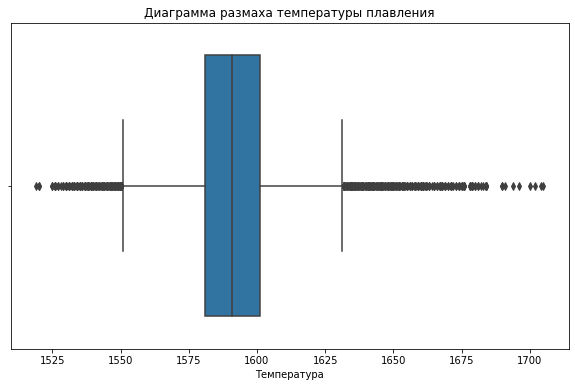

In [64]:
fig = plt.figure(figsize=(10,6))
sns.boxplot(data_temp['Температура'])
plt.xlabel('Температура')
plt.title("Диаграмма размаха температуры плавления")

Теперь данные рспределены нормально.

In [65]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [66]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 15902
Data columns (total 3 columns):
key             12999 non-null int64
Время замера    12999 non-null datetime64[ns]
Температура     12999 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.2 KB


In [67]:
data_temp = data_temp.sort_values(by=['key', 'Время замера'])
data_temp.head(20)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Данные отсортированы, сделаем группировку с подсчетом количества и выборкой первого и последнего значений.

In [68]:
df = data_temp.groupby('key').agg({'Температура': ['count', 'first', 'last']}).reset_index()
df

key Температура                
                 count   first    last
0        1           5  1571.0  1613.0
1        2           6  1581.0  1602.0
2        3           5  1596.0  1599.0
3        4           3  1601.0  1625.0
4        5           2  1576.0  1602.0
...    ...         ...     ...     ...
3210  3237           1  1569.0  1569.0
3211  3238           1  1584.0  1584.0
3212  3239           1  1598.0  1598.0
3213  3240           1  1617.0  1617.0
3214  3241           1  1586.0  1586.0

[3215 rows x 4 columns]

Выполним проверку на примере партии 5.

In [69]:
data_temp[data_temp['key'] == 5]

,key,Время замера,Температура
19,5,2019-05-03 13:23:19,1576.0
20,5,2019-05-03 13:36:01,1602.0


Группировка прошла верно, зададим корректное название столбцов.

In [70]:
df.columns = ['key', 'Количество замеров по температуре', 
              'Температура начальная', 'Температура конечная']

In [71]:
df

,key,Количество замеров по температуре,Температура начальная,Температура конечная
0,1,5,1571.0,1613.0
1,2,6,1581.0,1602.0
2,3,5,1596.0,1599.0
3,4,3,1601.0,1625.0
4,5,2,1576.0,1602.0
...,...,...,...,...
3210,3237,1,1569.0,1569.0
3211,3238,1,1584.0,1584.0
3212,3239,1,1598.0,1598.0
3213,3240,1,1617.0,1617.0


Избавимся от партий, где всего 1 замер.

In [72]:
df = df[df['Количество замеров по температуре'] > 1]

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 4 columns):
key                                  2475 non-null int64
Количество замеров по температуре    2475 non-null int64
Температура начальная                2475 non-null float64
Температура конечная                 2475 non-null float64
dtypes: float64(2), int64(2)
memory usage: 96.7 KB


Данные по температуре подготовлены.

### 1.6 Создание единого датасета со всеми данными

Определяющим параметром для создания единого датасетя является наличие температуры, поэтому последний полученный датасет *df* является основным, к нему будем мержить все остальные. Мержить будем с параметром how='left', т.к. если в других датасетах есть информация о партиях, по которым у нас нет измеренной температуры, то такую информацию добавлять нецелесообразно.

In [74]:
len(df['key'].unique())

2475

Всего 2475 партии с известной температурой.

In [75]:
df = df.merge(data_arc_batch, on=['key'], how='left')
df = df.merge(data_bulk, on=['key'], how='left')
df = df.merge(data_gas, on=['key'], how='left')
df = df.merge(data_wire, on=['key'], how='left')

In [76]:
df.head(10)

,key,Количество замеров по температуре,Температура начальная,Температура конечная,Затраченная энергия,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,5,1571.0,1613.0,400.660487,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,6,1581.0,1602.0,244.787101,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5,1596.0,1599.0,145.851882,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3,1601.0,1625.0,221.364253,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2,1576.0,1602.0,333.093877,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,5,1543.0,1596.0,391.874227,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,11.273392,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,5,1586.0,1599.0,202.716842,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,9.836267,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,4,1577.0,1598.0,430.706174,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,15.171553,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,5,1587.0,1592.0,112.905735,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,8.216623,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,8,1574.0,1593.0,171.489307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0,6.529891,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 30 columns):
key                                  2475 non-null int64
Количество замеров по температуре    2475 non-null int64
Температура начальная                2475 non-null float64
Температура конечная                 2475 non-null float64
Затраченная энергия                  2475 non-null float64
Bulk 1                               2407 non-null float64
Bulk 2                               2407 non-null float64
Bulk 3                               2407 non-null float64
Bulk 4                               2407 non-null float64
Bulk 5                               2407 non-null float64
Bulk 6                               2407 non-null float64
Bulk 7                               2407 non-null float64
Bulk 8                               2407 non-null float64
Bulk 9                               2407 non-null float64
Bulk 10                              2407 non-null float64
Bulk 11     

Данные объединены. Видим, что больше всего в наличии информации по партиям с известной температурой было в датасетах с газом  и нагревом (2475 для энергии и 2473 для газа) и меньше по присадкам - для сыпучих 2407, для проволочных 2372. Для того, чтобы данные были верные исключим из датасета те партии, по которым не было данных.

In [78]:
df = df.dropna()

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2474
Data columns (total 30 columns):
key                                  2329 non-null int64
Количество замеров по температуре    2329 non-null int64
Температура начальная                2329 non-null float64
Температура конечная                 2329 non-null float64
Затраченная энергия                  2329 non-null float64
Bulk 1                               2329 non-null float64
Bulk 2                               2329 non-null float64
Bulk 3                               2329 non-null float64
Bulk 4                               2329 non-null float64
Bulk 5                               2329 non-null float64
Bulk 6                               2329 non-null float64
Bulk 7                               2329 non-null float64
Bulk 8                               2329 non-null float64
Bulk 9                               2329 non-null float64
Bulk 10                              2329 non-null float64
Bulk 11     

Итого получилось 2329 партий для дальнейшего обучения машинного обучения и прогнозирования конечной температуры.

## 2 Обучение моделей машинного обучения

План обучения моделей машинного обучения:

1. Исключаем из датасета данные по номеру партии и количеству замеров по температуре.
2. Делим выборку на трейн и тест в соотношении 80 на 20.
3. Проводим масштабирование данных.
4. Обучаем модели с поиском оптимальных параметров с помощью GridSearchCV. Для обучения воспользуемся следующими алгоритмами: линейная регрессия, случайный лес, LightGBM, Сatboost.

### 2.1 Подготовка выборок для обучения

Для начала посмотрим на описательные статистики получившегося набора данных.

In [80]:
df.describe()

,key,Количество замеров по температуре,Температура начальная,Температура конечная,Затраченная энергия,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.0,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,4.982825,1587.386003,1593.365393,250.813069,3.427651,1.422499,47.348218,37.303564,2.640189,22.430228,2.004723,0.021039,0.444826,5.052812,4.245170,208.415629,1.067411,153.853585,119.952769,11.375600,102.443601,17.609859,3.234916,0.306550,0.0,0.978820,0.006361,0.311311,0.317113
std,714.762400,1.794574,23.619841,11.200915,180.765348,12.412132,19.082119,75.310430,58.643238,22.402293,55.790873,30.676234,1.015340,6.220641,20.917800,22.515487,157.062272,14.235055,81.404354,84.640443,6.392041,43.539993,33.624771,27.942871,4.757746,0.0,8.693299,0.205705,4.402707,3.456561
min,1.000000,2.000000,1519.000000,1541.000000,4.210582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,630.000000,4.000000,1571.000000,1587.000000,129.232078,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,7.282948,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1255.000000,5.000000,1587.000000,1593.000000,213.282721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.100950,101.119201,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1868.000000,6.000000,1603.000000,1598.000000,323.791821,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.000000,0.000000,204.000000,204.000000,14.216688,128.091599,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,16.000000,1660.000000,1653.000000,2953.050186,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995040,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


Видим, что по признаку wire 5 остались только нулевые значения, следовательно в полученные партии данный проволочный материал не добавлялся, и признак должен быть исключен. Также в данной операции сразу удалим данные по номеру партий и количество измерений температуры, проведенных для них.

In [81]:
df = df.drop(['key', 'Количество замеров по температуре', 'Wire 5'], axis=1)

In [82]:
df.head()

,Температура начальная,Температура конечная,Затраченная энергия,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1613.0,400.660487,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,244.787101,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,145.851882,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,221.364253,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,333.093877,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


Проверим наши данные на мультиколлинеарность.

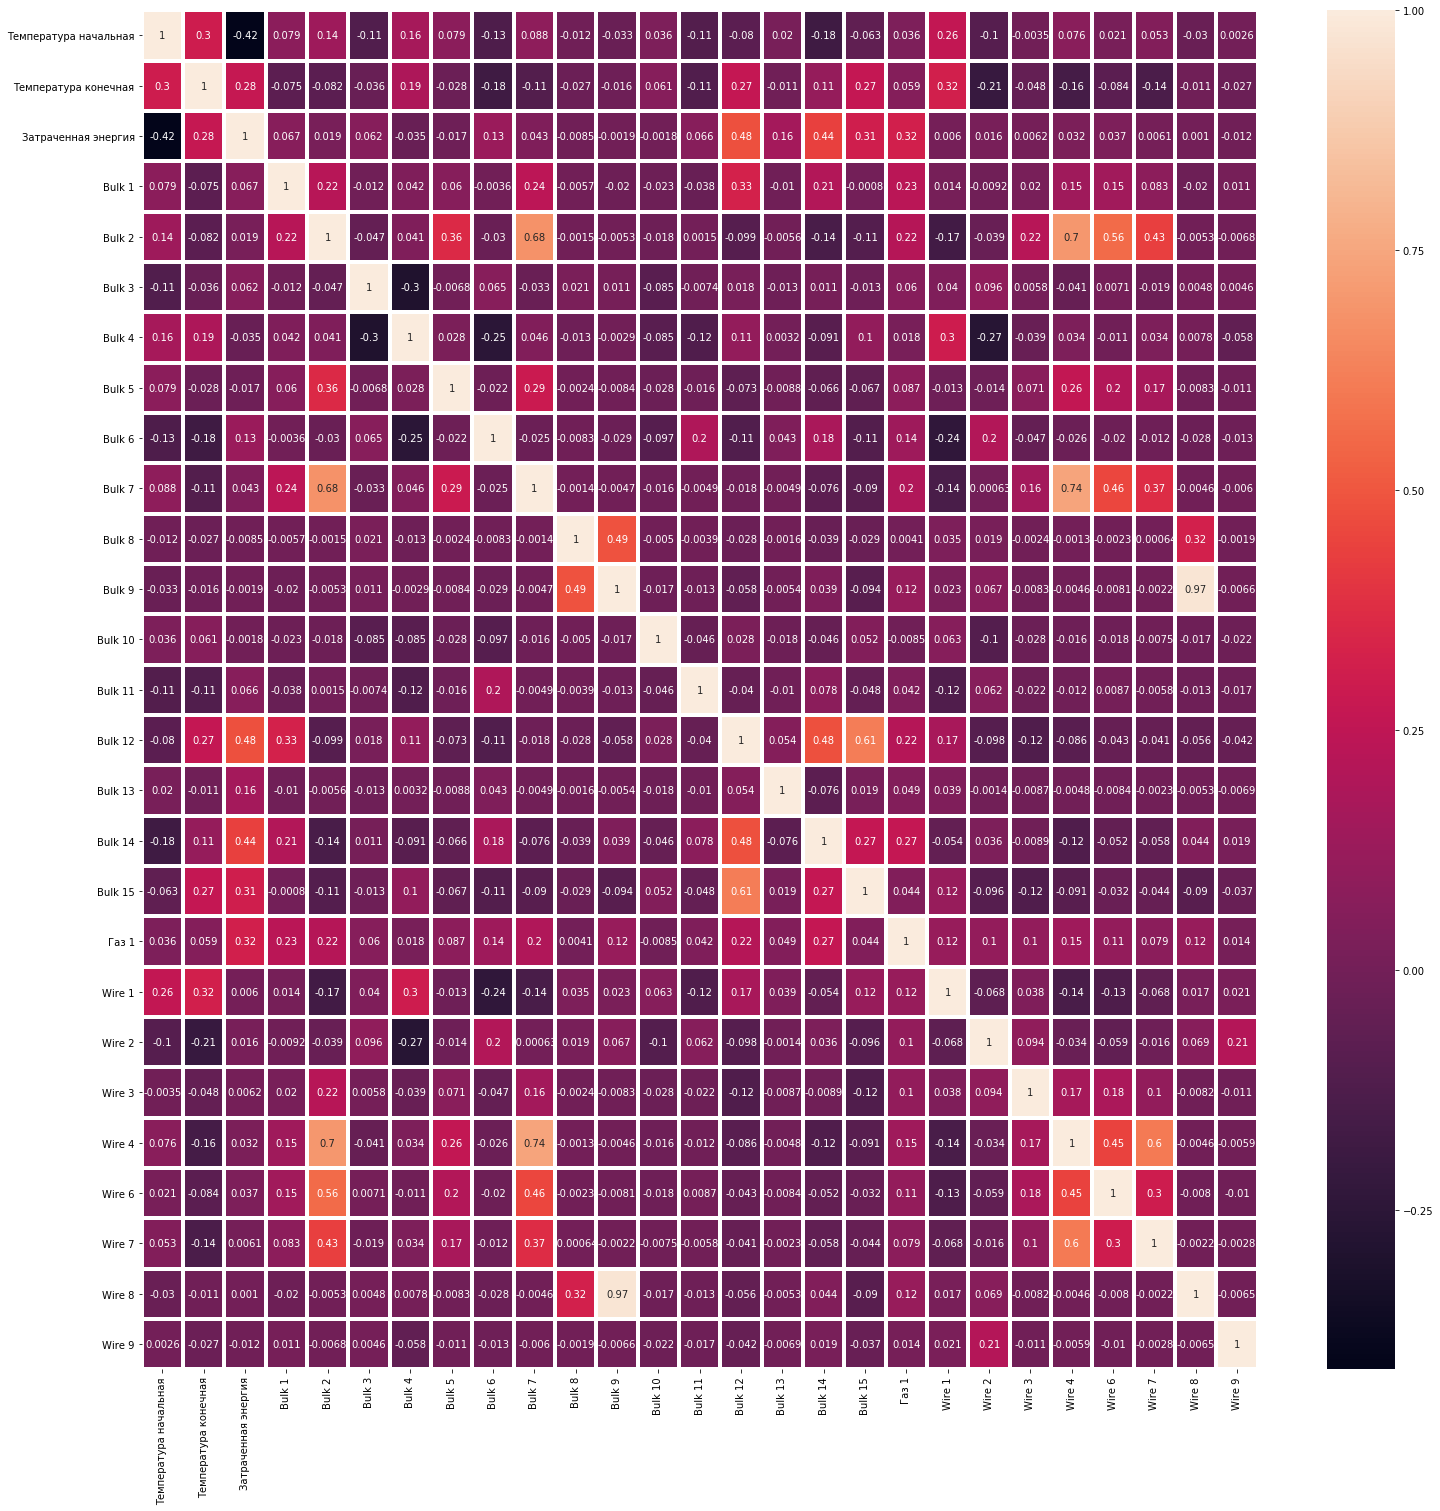

In [83]:
plt.rcParams['figure.figsize'] = (25, 25)
sns.heatmap(df.corr(), annot=True, linewidths=3, linecolor='white')

Heatmap получился красивый, но т.к. данных много, его сложно анализировать. Найдем только те параметры, у которых корреляция превышает 0,7 по модулю.

In [84]:
corr_table = df.corr().unstack().sort_values().drop_duplicates()

corr_table[(corr_table > 0.7) | (corr_table < -0.7)]

Bulk 7                 Wire 4                   0.740572
Bulk 9                 Wire 8                   0.974969
Температура начальная  Температура начальная    1.000000
dtype: float64

Выявлена весьма высокая корреляция между признаками Bulk 9 и Wire 8. При такой корреляции один из признаков необходимо исключить из датасета, иначе будут получены худшие результаты работы моделей. Т.к. количество сыпучих материалов больше, чем количество проволочных материалов, то исключим признак Bulk 9.

In [85]:
df = df.drop('Bulk 9', axis=1)

Переименуем столбцы, потому что некоторые алгоритмы не воспринимают русский текст.

In [86]:
df = df.rename(columns={'Температура начальная': 'start_temp', 
                        'Температура конечная': 'final_temp', 
                       'Затраченная энергия':'energy',
                       'Газ 1': 'gas'})

In [87]:
df.describe()

,start_temp,final_temp,energy,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1587.386003,1593.365393,250.813069,3.427651,1.422499,47.348218,37.303564,2.640189,22.430228,2.004723,0.021039,5.052812,4.245170,208.415629,1.067411,153.853585,119.952769,11.375600,102.443601,17.609859,3.234916,0.306550,0.978820,0.006361,0.311311,0.317113
std,23.619841,11.200915,180.765348,12.412132,19.082119,75.310430,58.643238,22.402293,55.790873,30.676234,1.015340,20.917800,22.515487,157.062272,14.235055,81.404354,84.640443,6.392041,43.539993,33.624771,27.942871,4.757746,8.693299,0.205705,4.402707,3.456561
min,1519.000000,1541.000000,4.210582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1571.000000,1587.000000,129.232078,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,7.282948,73.207679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1587.000000,1593.000000,213.282721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.100950,101.119201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1603.000000,1598.000000,323.791821,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.000000,0.000000,204.000000,204.000000,14.216688,128.091599,23.102560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1660.000000,1653.000000,2953.050186,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995040,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,62.025600


Получим обучающую и тестовую выборки. Валидационную выборку не выделяем, т.к. будем применять кросс-валидацию внутри GridSearchCV.

In [88]:
target = df['final_temp']
features = df.drop('final_temp', axis=1)
    
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.2, random_state=12345) # разделили выборки в пропорции 2 к 8

In [89]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(1863, 25)
(466, 25)
(1863,)
(466,)


Выборки получены, проведем масштабирование данных с помощью StandardScaler.

In [90]:
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])
    
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [91]:
features_train.describe()

,start_temp,energy,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
count,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1863.0,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03,1.863000e+03
mean,-2.113893e-15,3.909320e-17,1.620938e-17,-1.525588e-17,1.334890e-17,3.813971e-17,-3.813971e-18,-5.148860e-17,1.096517e-17,0.0,-4.958162e-17,-9.534927e-19,1.001167e-16,1.525588e-17,5.530257e-17,-5.816305e-17,-1.382564e-16,-3.432574e-16,1.906985e-17,1.334890e-17,-1.811636e-17,3.813971e-18,-9.534927e-18,2.097684e-17,-9.534927e-18
std,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,0.0,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00,1.000268e+00
min,-2.909218e+00,-1.342436e+00,-2.769226e-01,-6.552010e-02,-6.172309e-01,-6.358092e-01,-1.276284e-01,-4.090839e-01,-6.470877e-02,0.0,-2.393888e-01,-1.943570e-01,-1.322438e+00,-6.713760e-02,-1.911755e+00,-1.414528e+00,-1.787720e+00,-2.340930e+00,-5.256454e-01,-1.104298e-01,-6.219929e-02,-1.085378e-01,-3.230324e-02,-6.566747e-02,-8.497725e-02
25%,-6.970595e-01,-6.624801e-01,-2.769226e-01,-6.552010e-02,-6.172309e-01,-6.358092e-01,-1.276284e-01,-4.090839e-01,-6.470877e-02,0.0,-2.393888e-01,-1.943570e-01,-6.600883e-01,-6.713760e-02,-5.994943e-01,-1.414528e+00,-6.368131e-01,-6.822631e-01,-5.256454e-01,-1.104298e-01,-6.219929e-02,-1.085378e-01,-3.230324e-02,-6.566747e-02,-8.497725e-02
50%,-1.639549e-02,-2.139156e-01,-2.769226e-01,-6.552010e-02,-6.172309e-01,-6.358092e-01,-1.276284e-01,-4.090839e-01,-6.470877e-02,0.0,-2.393888e-01,-1.943570e-01,-2.297055e-02,-6.713760e-02,-6.716202e-02,-1.614016e-01,-1.909480e-01,-3.428779e-02,-5.256454e-01,-1.104298e-01,-6.219929e-02,-1.085378e-01,-3.230324e-02,-6.566747e-02,-8.497725e-02
75%,6.642685e-01,3.871463e-01,-2.769226e-01,-6.552010e-02,3.971133e-01,6.757840e-01,-1.276284e-01,-4.090839e-01,-6.470877e-02,0.0,-2.393888e-01,-1.943570e-01,5.037555e-01,-6.713760e-02,6.137281e-01,9.971493e-01,4.350976e-01,5.845206e-01,1.491822e-01,-1.104298e-01,-6.219929e-02,-1.085378e-01,-3.230324e-02,-6.566747e-02,-8.497725e-02
max,3.089134e+00,1.454216e+01,1.466636e+01,1.705987e+01,5.522932e+00,4.119774e+00,1.490953e+01,6.131261e+00,2.424098e+01,0.0,7.373175e+00,1.059027e+01,1.034123e+01,2.470467e+01,5.961810e+00,3.373361e+00,1.062533e+01,5.199729e+00,6.572062e+00,1.415198e+01,2.400681e+01,1.973615e+01,3.710061e+01,1.536971e+01,1.773344e+01


In [92]:
features_test.describe()

,start_temp,energy,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000
mean,0.000128,-0.070249,-0.000279,0.104285,0.115622,-0.022449,0.039331,-0.002223,-0.007956,0.105150,0.012637,-0.025853,-0.038646,0.097741,-0.035362,0.017729,0.107878,-0.011359,0.070504,0.047008,0.014807,-0.004480,-0.022411,0.191765,0.107414
std,1.023921,0.858195,1.012870,1.645562,1.084744,0.961477,1.615571,1.079660,0.814544,2.269881,1.007411,1.016610,0.952235,1.636465,1.037840,1.002949,1.080072,0.969345,1.143368,1.164528,1.055433,0.754436,0.213536,2.608112,1.651387
min,-2.398720,-1.279174,-0.276923,-0.065520,-0.617231,-0.635809,-0.127628,-0.409084,-0.064709,0.000000,-0.239389,-0.194357,-1.322438,-0.067138,-1.911755,-1.414528,-1.626978,-2.340930,-0.525645,-0.110430,-0.062199,-0.108538,-0.032303,-0.065667,-0.084977
25%,-0.697060,-0.701645,-0.276923,-0.065520,-0.617231,-0.635809,-0.127628,-0.409084,-0.064709,0.000000,-0.239389,-0.194357,-0.660088,-0.067138,-0.621159,-1.414528,-0.599975,-0.620350,-0.525645,-0.110430,-0.062199,-0.108538,-0.032303,-0.065667,-0.084977
50%,-0.058937,-0.228063,-0.276923,-0.065520,-0.617231,-0.635809,-0.127628,-0.409084,-0.064709,0.000000,-0.239389,-0.194357,-0.022971,-0.067138,-0.141441,-0.013627,-0.151470,-0.010783,-0.525645,-0.110430,-0.062199,-0.108538,-0.032303,-0.065667,-0.084977
75%,0.749352,0.331829,-0.276923,-0.065520,0.559408,0.650398,-0.127628,-0.409084,-0.064709,0.000000,-0.239389,-0.194357,0.317667,-0.067138,0.613728,0.997149,0.587183,0.539755,0.259882,-0.110430,-0.062199,-0.108538,-0.032303,-0.065667,-0.084977
max,3.089134,4.512724,7.154332,19.671188,4.413916,3.459746,30.819142,8.754686,15.897707,49.000000,5.793209,13.754355,3.566337,22.511760,3.250630,3.373361,6.261871,2.911249,8.141729,10.269999,19.615074,6.952970,4.577300,34.276489,20.739842


Масштабирование признаков проведено.

### 2.2 Обучение моделей

Определять оптимальные параметры для каждой модели будем с помощью GridSearchCV. Будем брать 5 фолдов для кросс-валидации, в качестве скорера примем "neg_mean_absolute_error".
Обучим следующие модели:
* LinearRegression
* RandomForestRegressor
* LGBMRegressor
* CatBoostRegressor

In [93]:
# создадим функцию для необходимого скора
def mae_score (target, predictions):
    mae = mean_absolute_error(target, predictions)
    return mae
scorer = make_scorer(mae_score, greater_is_better=False)

#### 2.2.1 Линейная регрессия

In [94]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = GridSearchCV(model, parameters, cv=5, scoring=scorer, verbose=5)
grid.fit(features_train, target_train)
print("MAE линейной регрессии составляет ", -grid.best_score_)
print('Наилучшие подобранные параметры для линейной регрессии')
grid.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] fit_intercept=True, normalize=True ..............................
[CV] . fit_intercept=True, normalize=True, score=-6.479, total=   0.0s
[CV] fit_intercept=True, normalize=True ..............................
[CV]  fit_intercept=True, normalize=True, score=-12.490, total=   0.0s
[CV] fit_intercept=True, normalize=True ..............................
[CV] . fit_intercept=True, normalize=True, score=-6.336, total=   0.1s
[CV] fit_intercept=True, normalize=True ..............................
[CV] . fit_intercept=True, normalize=True, score=-6.439, total=   0.1s
[CV] fit_intercept=True, normalize=True ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


[CV] . fit_intercept=True, normalize=True, score=-6.482, total=   0.1s
[CV] fit_intercept=True, normalize=False .............................
[CV]  fit_intercept=True, normalize=False, score=-6.479, total=   0.1s
[CV] fit_intercept=True, normalize=False .............................
[CV]  fit_intercept=True, normalize=False, score=-12.490, total=   0.1s
[CV] fit_intercept=True, normalize=False .............................
[CV]  fit_intercept=True, normalize=False, score=-6.336, total=   0.0s
[CV] fit_intercept=True, normalize=False .............................
[CV]  fit_intercept=True, normalize=False, score=-6.439, total=   0.1s
[CV] fit_intercept=True, normalize=False .............................
[CV]  fit_intercept=True, normalize=False, score=-6.482, total=   0.1s
[CV] fit_intercept=False, normalize=True .............................
[CV]  fit_intercept=False, normalize=True, score=-1621.607, total=   0.1s
[CV] fit_intercept=False, normalize=True .............................
[C

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.5s finished


{'fit_intercept': True, 'normalize': False}

MAE линейной регрессии составляет  7.646687086578328<br>
Наилучшие подобранные параметры для линейной регрессии: {'fit_intercept': True, 'normalize': False}

#### 2.2.2 Случайный лес

In [95]:
forest = RandomForestRegressor(random_state=12345)
    
forest_params = {'n_estimators': range(30, 81, 10),
                 'max_depth': range(1,12)}

forest_grid = GridSearchCV(forest, forest_params,
                         cv=5, verbose=5, scoring=scorer)

forest_grid.fit(features_train, target_train)

print("MAE для случайного леса составляет ", -forest_grid.best_score_)


print('Наилучшие подобранные параметры для случайного леса')
print(forest_grid.best_params_)

Fitting 5 folds for each of 66 candidates, totalling 330 fits
[CV] max_depth=1, n_estimators=30 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... max_depth=1, n_estimators=30, score=-7.839, total=   0.2s
[CV] max_depth=1, n_estimators=30 ....................................
[CV] ....... max_depth=1, n_estimators=30, score=-7.583, total=   0.0s
[CV] max_depth=1, n_estimators=30 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ....... max_depth=1, n_estimators=30, score=-7.966, total=   0.1s
[CV] max_depth=1, n_estimators=30 ....................................
[CV] ....... max_depth=1, n_estimators=30, score=-7.718, total=   0.0s
[CV] max_depth=1, n_estimators=30 ....................................
[CV] ....... max_depth=1, n_estimators=30, score=-7.645, total=   0.0s
[CV] max_depth=1, n_estimators=40 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV] ....... max_depth=1, n_estimators=40, score=-7.839, total=   0.1s
[CV] max_depth=1, n_estimators=40 ....................................
[CV] ....... max_depth=1, n_estimators=40, score=-7.566, total=   0.1s
[CV] max_depth=1, n_estimators=40 ....................................
[CV] ....... max_depth=1, n_estimators=40, score=-7.985, total=   0.1s
[CV] max_depth=1, n_estimators=40 ....................................
[CV] ....... max_depth=1, n_estimators=40, score=-7.668, total=   0.1s
[CV] max_depth=1, n_estimators=40 ....................................
[CV] ....... max_depth=1, n_estimators=40, score=-7.660, total=   0.1s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ....... max_depth=1, n_estimators=50, score=-7.838, total=   0.1s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ....... max_depth=1, n_estimators=50, score=-7.561, total=   0.1s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 330 out of 330 | elapsed:  1.2min finished


MAE для случайного леса составляет  6.177930229519781
Наилучшие подобранные параметры для случайного леса
{'max_depth': 10, 'n_estimators': 70}


MAE для случайного леса составляет  6.177930229519781 <br>
Наилучшие подобранные параметры для случайного леса<br>
{'max_depth': 10, 'n_estimators': 70}

#### 2.2.3 Light GBM

In [96]:
gbm = LGBMRegressor(random_state=12345)
    
g_params = {'n_estimators': [50, 100, 500],
              'num_leaves': [21, 31, 41], 
              'learning_rate':[0.01, .04, 0.06]}

g_grid = GridSearchCV(gbm, g_params,
                         cv=5, verbose=5, scoring=scorer)

g_grid.fit(features_train, target_train)

print("MAE для LGBM составляет ", -g_grid.best_score_)


print('Наилучшие подобранные параметры для LGBM')
print(g_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] learning_rate=0.01, n_estimators=50, num_leaves=21 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=21, score=-7.395, total=   0.4s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=21 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=21, score=-7.105, total=   0.4s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=21 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=21, score=-7.223, total=   0.5s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=21 ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=21, score=-7.125, total=   0.4s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=21 ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=21, score=-7.143, total=   0.4s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=-7.325, total=   0.5s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=-7.044, total=   0.5s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=-7.170, total=   0.5s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=-7.100, total=   0.5s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=-7.087, total=   0.5s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=41 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=41, 

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  4.6min finished


MAE для LGBM составляет  6.146529575044108
Наилучшие подобранные параметры для LGBM
{'learning_rate': 0.04, 'n_estimators': 100, 'num_leaves': 21}


MAE для LGBM составляет  6.146529575044108<br>
Наилучшие подобранные параметры для LGBM<br>
{'learning_rate': 0.04, 'n_estimators': 100, 'num_leaves': 21}

#### 2.2.4 CatBoost

In [97]:
cbr = CatBoostRegressor(loss_function="MAE")

grid = {'learning_rate': [0.03, 0.1, 0.5],
        'iterations': [150, 500]}

cbr_grid = GridSearchCV(cbr, grid,
                         cv=5, verbose=5, scoring=scorer)

cbr_grid.fit(features_train, target_train)

print("MAE для CBR составляет ", -cbr_grid.best_score_)


print('Наилучшие подобранные параметры для CBR')
print(cbr_grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] iterations=150, learning_rate=0.03 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 7.9476634	total: 48.8ms	remaining: 7.27s
1:	learn: 7.8897016	total: 50.2ms	remaining: 3.72s
2:	learn: 7.8135406	total: 51.6ms	remaining: 2.53s
3:	learn: 7.7565695	total: 52.9ms	remaining: 1.93s
4:	learn: 7.7017822	total: 54.3ms	remaining: 1.57s
5:	learn: 7.6521975	total: 55.7ms	remaining: 1.33s
6:	learn: 7.5922327	total: 57ms	remaining: 1.16s
7:	learn: 7.5456222	total: 58.3ms	remaining: 1.03s
8:	learn: 7.5077956	total: 110ms	remaining: 1.73s
9:	learn: 7.4543015	total: 112ms	remaining: 1.56s
10:	learn: 7.4103173	total: 113ms	remaining: 1.43s
11:	learn: 7.3801070	total: 115ms	remaining: 1.32s
12:	learn: 7.3350006	total: 116ms	remaining: 1.22s
13:	learn: 7.2917726	total: 117ms	remaining: 1.14s
14:	learn: 7.2595039	total: 119ms	remaining: 1.07s
15:	learn: 7.2093384	total: 125ms	remaining: 1.05s
16:	learn: 7.1776433	total: 208ms	remaining: 1.62s
17:	learn: 7.1359068	total: 209ms	remaining: 1.53s
18:	learn: 7.0866635	total: 211ms	remaining: 1.45s
19:	learn: 7.0428872	total: 212ms	r

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


0:	learn: 7.9842205	total: 1.81ms	remaining: 271ms
1:	learn: 7.9497346	total: 3.38ms	remaining: 250ms
2:	learn: 7.8778114	total: 4.74ms	remaining: 232ms
3:	learn: 7.8327708	total: 6.1ms	remaining: 223ms
4:	learn: 7.7671224	total: 7.43ms	remaining: 215ms
5:	learn: 7.7075932	total: 8.78ms	remaining: 211ms
6:	learn: 7.6441809	total: 10.1ms	remaining: 206ms
7:	learn: 7.5850807	total: 11.5ms	remaining: 205ms
8:	learn: 7.5410819	total: 28.2ms	remaining: 442ms
9:	learn: 7.4872821	total: 29.8ms	remaining: 417ms
10:	learn: 7.4393424	total: 31.4ms	remaining: 396ms
11:	learn: 7.4073831	total: 32.7ms	remaining: 376ms
12:	learn: 7.3692051	total: 34ms	remaining: 358ms
13:	learn: 7.3212791	total: 35.2ms	remaining: 342ms
14:	learn: 7.2849342	total: 36.5ms	remaining: 329ms
15:	learn: 7.2381789	total: 37.8ms	remaining: 317ms
16:	learn: 7.1920576	total: 126ms	remaining: 982ms
17:	learn: 7.1415976	total: 128ms	remaining: 936ms
18:	learn: 7.0987549	total: 130ms	remaining: 896ms
19:	learn: 7.0582655	total: 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


0:	learn: 7.9414755	total: 2.02ms	remaining: 300ms
1:	learn: 7.8889324	total: 3.52ms	remaining: 261ms
2:	learn: 7.8253432	total: 4.93ms	remaining: 242ms
3:	learn: 7.7689409	total: 7.03ms	remaining: 257ms
4:	learn: 7.7187519	total: 8.46ms	remaining: 245ms
5:	learn: 7.6678941	total: 9.86ms	remaining: 237ms
6:	learn: 7.6182306	total: 16.6ms	remaining: 339ms
7:	learn: 7.5780918	total: 30.9ms	remaining: 549ms
8:	learn: 7.5368545	total: 32.3ms	remaining: 506ms
9:	learn: 7.4848811	total: 34.1ms	remaining: 478ms
10:	learn: 7.4411083	total: 36.4ms	remaining: 461ms
11:	learn: 7.4080644	total: 37.8ms	remaining: 434ms
12:	learn: 7.3581678	total: 39.1ms	remaining: 412ms
13:	learn: 7.3189722	total: 40.4ms	remaining: 393ms
14:	learn: 7.2750297	total: 47.1ms	remaining: 424ms
15:	learn: 7.2371992	total: 53.7ms	remaining: 450ms
16:	learn: 7.1997988	total: 128ms	remaining: 1s
17:	learn: 7.1752739	total: 130ms	remaining: 951ms
18:	learn: 7.1503194	total: 131ms	remaining: 903ms
19:	learn: 7.1143121	total: 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s


0:	learn: 8.0527086	total: 1.69ms	remaining: 251ms
1:	learn: 7.9863677	total: 3.19ms	remaining: 236ms
2:	learn: 7.9254574	total: 4.74ms	remaining: 232ms
3:	learn: 7.8670570	total: 6.08ms	remaining: 222ms
4:	learn: 7.8033036	total: 7.49ms	remaining: 217ms
5:	learn: 7.7464367	total: 8.81ms	remaining: 211ms
6:	learn: 7.7009845	total: 10.1ms	remaining: 206ms
7:	learn: 7.6405682	total: 16.7ms	remaining: 297ms
8:	learn: 7.5950289	total: 95.5ms	remaining: 1.5s
9:	learn: 7.5444870	total: 96.9ms	remaining: 1.36s
10:	learn: 7.5054733	total: 99.1ms	remaining: 1.25s
11:	learn: 7.4795669	total: 100ms	remaining: 1.15s
12:	learn: 7.4304210	total: 102ms	remaining: 1.07s
13:	learn: 7.3700369	total: 103ms	remaining: 1s
14:	learn: 7.3483555	total: 104ms	remaining: 939ms
15:	learn: 7.3039807	total: 106ms	remaining: 885ms
16:	learn: 7.2604782	total: 193ms	remaining: 1.51s
17:	learn: 7.2071975	total: 194ms	remaining: 1.43s
18:	learn: 7.1590384	total: 196ms	remaining: 1.35s
19:	learn: 7.1173838	total: 197ms	

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.6s remaining:    0.0s


0:	learn: 7.9954651	total: 1.79ms	remaining: 267ms
1:	learn: 7.9475677	total: 3.23ms	remaining: 239ms
2:	learn: 7.8819319	total: 4.69ms	remaining: 230ms
3:	learn: 7.8355221	total: 5.97ms	remaining: 218ms
4:	learn: 7.7802415	total: 7.39ms	remaining: 214ms
5:	learn: 7.7171096	total: 8.74ms	remaining: 210ms
6:	learn: 7.6629227	total: 10.1ms	remaining: 205ms
7:	learn: 7.5961088	total: 16.6ms	remaining: 296ms
8:	learn: 7.5494666	total: 34.9ms	remaining: 547ms
9:	learn: 7.5074411	total: 36.4ms	remaining: 510ms
10:	learn: 7.4502414	total: 37.8ms	remaining: 478ms
11:	learn: 7.3986125	total: 39.1ms	remaining: 450ms
12:	learn: 7.3508919	total: 40.4ms	remaining: 425ms
13:	learn: 7.3047252	total: 41.7ms	remaining: 405ms
14:	learn: 7.2544446	total: 42.9ms	remaining: 386ms
15:	learn: 7.2221161	total: 49.8ms	remaining: 417ms
16:	learn: 7.1793935	total: 56.5ms	remaining: 442ms
17:	learn: 7.1450226	total: 133ms	remaining: 973ms
18:	learn: 7.1065030	total: 134ms	remaining: 925ms
19:	learn: 7.0626134	tot

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.5min finished


0:	learn: 7.9733270	total: 2.11ms	remaining: 1.05s
1:	learn: 7.9401128	total: 3.81ms	remaining: 949ms
2:	learn: 7.8763227	total: 5.27ms	remaining: 874ms
3:	learn: 7.8154333	total: 6.69ms	remaining: 829ms
4:	learn: 7.7484352	total: 8.15ms	remaining: 807ms
5:	learn: 7.6918295	total: 9.71ms	remaining: 799ms
6:	learn: 7.6380343	total: 11.2ms	remaining: 786ms
7:	learn: 7.6014269	total: 12.6ms	remaining: 775ms
8:	learn: 7.5530388	total: 101ms	remaining: 5.51s
9:	learn: 7.4967316	total: 103ms	remaining: 5.03s
10:	learn: 7.4616274	total: 104ms	remaining: 4.64s
11:	learn: 7.4222526	total: 106ms	remaining: 4.3s
12:	learn: 7.3740668	total: 107ms	remaining: 4.02s
13:	learn: 7.3320611	total: 109ms	remaining: 3.77s
14:	learn: 7.2994526	total: 110ms	remaining: 3.56s
15:	learn: 7.2512851	total: 111ms	remaining: 3.37s
16:	learn: 7.2057343	total: 198ms	remaining: 5.64s
17:	learn: 7.1596578	total: 202ms	remaining: 5.42s
18:	learn: 7.1212214	total: 204ms	remaining: 5.16s
19:	learn: 7.0787372	total: 205ms	

MAE для CBR составляет  5.99243467082956<br>
Наилучшие подобранные параметры для CBR<br>
{'iterations': 500, 'learning_rate': 0.03}

**Вывод по проведенному обучению моделей:**

Все обученные модели побили минимальный порог (8.7 градусов) MAE внутри кросс-валидации. При этом наилучший скор был получен с помощью применения модели CatBoostRegressor. Проведем проверку работы моделей на тестовой выборке.

## 3 Анализ моделей

In [98]:
# создадим таблицу для хранения результатов
d = {'model': [], 'MAE':[], 'fit_time': [], 'predict_time':[]}
results = pd.DataFrame(data=d)
results

,model,MAE,fit_time,predict_time


In [99]:
# создадим функцию для добавления результатов в таблицу
def model_res(model_name, model, features_train, target_train, features_test, target_test):
    mae, fit_time, pred_time = ml(model, features_train, target_train, features_test, target_test)
    results.loc[len(results)] = [model_name, mae, fit_time, pred_time]
    if len(results) > 0: # исключим дублировании при неоднократном выполнении функции для одной и той же модели
        results.drop_duplicates(inplace=True)

In [100]:
# cоздадим функцию для расчета необходимых параметров
def ml (model, features_train, target_train, features_test, target_test):
    start_fit_time = time.time()
    model.fit(features_train, target_train)
    stop_fit_time = time.time()
    
    fit_time = stop_fit_time - start_fit_time
    
    start_predict_time = time.time()
    predictions = model.predict(features_test)
    stop_predict_time = time.time()
    
    pred_time = stop_predict_time - start_predict_time
    
    mae = mean_absolute_error(target_test, predictions)
    
    return mae, fit_time, pred_time

In [101]:
# линейная регрессия
lr = LinearRegression(fit_intercept=True, normalize=False)
model_res('LinearRegression', lr,  features_train, target_train,
          features_test, target_test)

In [102]:
# случайный лес
rf = RandomForestRegressor(max_depth=10, n_estimators=70, random_state=12345)
model_res('RandomForestRegressor', rf,  features_train, target_train,
          features_test, target_test)

In [103]:
# Light GBM
lgbm = LGBMRegressor(learning_rate=0.04, n_estimators=100, num_leaves=21, random_state=12345)
model_res('LGBMRegressor', lgbm,  features_train, target_train,
          features_test, target_test)

In [104]:
# CatBoost

cb = CatBoostRegressor(loss_function="MAE",
                         learning_rate=0.03, 
                         iterations=500,
                         random_state=12345)
model_res('CatBoostRegressor', cb,  features_train, target_train,
          features_test, target_test)

0:	learn: 7.9867408	total: 1.98ms	remaining: 988ms
1:	learn: 7.9159939	total: 3.74ms	remaining: 932ms
2:	learn: 7.8728161	total: 5.31ms	remaining: 880ms
3:	learn: 7.8145146	total: 6.89ms	remaining: 854ms
4:	learn: 7.7779983	total: 8.5ms	remaining: 841ms
5:	learn: 7.7444427	total: 11ms	remaining: 907ms
6:	learn: 7.7058625	total: 14ms	remaining: 984ms
7:	learn: 7.6613024	total: 16.8ms	remaining: 1.03s
8:	learn: 7.6048602	total: 20ms	remaining: 1.09s
9:	learn: 7.5444963	total: 22.1ms	remaining: 1.08s
10:	learn: 7.4952667	total: 23.6ms	remaining: 1.05s
11:	learn: 7.4422764	total: 110ms	remaining: 4.46s
12:	learn: 7.4008856	total: 111ms	remaining: 4.17s
13:	learn: 7.3550807	total: 114ms	remaining: 3.94s
14:	learn: 7.3122266	total: 115ms	remaining: 3.73s
15:	learn: 7.2580624	total: 117ms	remaining: 3.55s
16:	learn: 7.2120069	total: 120ms	remaining: 3.41s
17:	learn: 7.1651260	total: 127ms	remaining: 3.4s
18:	learn: 7.1391029	total: 207ms	remaining: 5.25s
19:	learn: 7.1059779	total: 209ms	rema

In [105]:
dummy = DummyRegressor(strategy='mean')
model_res('DummyRegressor', dummy,  features_train, target_train,
          features_test, target_test)

In [106]:
results

,model,MAE,fit_time,predict_time
0,LinearRegression,6.525527,0.002432,0.000684
1,RandomForestRegressor,6.169916,0.590343,0.007680
2,LGBMRegressor,6.191491,0.894607,0.005427
3,CatBoostRegressor,6.012490,7.412798,0.002392
4,DummyRegressor,8.155160,0.000323,0.000126


**Вывод по тестированию моделей**

И на тестовой выборке все модели побили минимальное значение MAE. Наилучшее значение MAE 6.012 было получено с помощью модели CatBoostRegressor с подобранными гиперпараметрами iterations = 500 и learning_rate = 0.03. Несмотря на наилучший скор, модель на основе CatBoostRegressor обладает наибольшим временем обучения. На выборке предоставленного размера это проявляется незначительно, но на больших выборках возможно оптимальнее было бы выбрать применение модели случайного леса или LGBMRegressor.

Также для проверки модели был применен DummyRegressor с стратегией заполнения средним значением. Заполнение средним значением не дало лучшего результата, чем применение моделей машинного обучения.

## ОБЩИЙ ВЫВОД ПО ПРОЕКТУ

В **первой части** проекта было проведено исследование и предобработка всех предоставленных датасетов.
По результатам исследования было выявлено и выполнено следующее:
1. В данных по работе электродов было расчитано время каждого нагрева.
2. На основе данных о времени каждого нагрева и зафиксрованных мощностей посчитана потребленная электроэнергия в КВА*ч.
3. Посчитанная потребленная электроэнергия была сгруппирована по 3214 партиям, т.о. был получен первый признак для наших моделей.
4. Были рассмотрены данные о сыпучих и проволочных материалах. В данных об объемах было выявлено много пропусков, что означает, что данные материалы не добавлялись в текущую партию, поэтому пропуски в датасетах с объемами были заменены на 0.
5. Также были оценены данные по времени добавления присадок. Выявлена та же структура данных, что и у объемов. Был сделан вывод, что использование данных со временем не требуется, т.к. в рамках проекта не решается задача временных рядов.
6. Была проведена оценка с данных о добавлении газа. Данные имеют нормальное распределение и имеются практически для всех партий, содержащихся в датасете (3239 партий).
7. Был проведен анализ измеренных в ходе технологического процесса температур, в результате которого выявлены явные выбросы ниже 1400 градусов, а также ряд партий с всего 1 измерением. По информации от заказчика такие партии не должны рассматриваться в проекте, поэтому были исключены.
8. Все значения температур были сгруппированы по партиям, при этом в качестве одного из обучающих признаков взято первое измеренное значение, а в качестве таргета - последнее измеренное значение.
9. В качестве завершающего этапа по предобработке данных все датасеты были объединены в один общий. При этом партии, по которым есть данные о температуре, но нет каких либо других данных были исключены из датасета.

Во **второй части** проекта была проведена подготовка выборок и дальнейшее обучение моделей. Было сделано следующее:
1. Была выявлена сильная взаимосвязь между признаками Bulk 9 и Wire 8 (коэффициент корреляции равен 0.974969), поэтому один из признаков (Bulk 9) был исключен из датасета.
2. Также были исключены из общего датасета данные по партиям и количеству замеров по температуре.
3. Для всех моделей был применен поиск оптимальных параметров с помощью GridSearchCV и кросс-валидации с 5 фолдами.
4. Была обучена модель линейной регрессии: получен MAE=7.647 с параметрами fit_intercept': True, 'normalize': False.
5. Была обучена модель случайного леса: получен MAE=6.178 с параметрами max_depth : 10, 'n_estimators' : 70.
6. Была обучена модель LightGBM: получен MAE=6.147 с параметрами 'learning_rate': 0.04, 'n_estimators': 100, 'num_leaves': 21.
7. Была обучена модель CatBoost: получен МАЕ=5.99243467082956 с параметрами 'iterations': 500, 'learning_rate': 0.03.

В **третьей части** проекта каждая модель была проверена на отложенной тестовой выборке. По итогу тестирования наилучшие результаты (МАЕ = 6.012) были получены с помощью модели CatBoostRegressor с подобранными гиперпараметрами iterations = 500 и learning_rate = 0.03.

Таким образом, можно заключить, что поставленная задача проекта выполнена, - получена почти максимальная точность, установленная в требованиях заказчика.